# **Quantitative Methods In Finance Final Project: By Azfina and Ben**

**Project Description:**

This notebook prices European vanilla and down-and-out barrier call options under a unified Black–Scholes framework. Closed-form Black–Scholes formulas and Monte Carlo GBM simulations are used as baseline methods for vanilla options, then applied and compared on down-and-out barrier options. Additional pricing approaches—finite-difference solutions of the Black–Scholes PDE and Monte Carlo simulation under the Heston stochastic volatility model—are implemented for the barrier case. The notebook runs structured experiments to compare accuracy, convergence, and sensitivity to maturity, barrier level, and volatility across all methods.

### Imports

In [1]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf

### Model Definitions

#### Vanilla Option Pricing Models

In [2]:
def bs_call_price(S0, K, T, r, q, sigma):
    if T <= 0:
        return max(S0 - K, 0.0)
    if sigma <= 0:
        # deterministic limit under forward drift
        fwd = S0 * np.exp((r - q) * T)
        return np.exp(-r * T) * max(fwd - K, 0.0)

    d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


In [3]:
def mc_gbm_vanilla_call(S0, K, T, r, q, sigma, n_paths=100_000, seed=42, antithetic=True):
    rng = np.random.default_rng(seed)
    if antithetic:
        m = n_paths // 2
        z = rng.standard_normal(m)
        z = np.concatenate([z, -z])
    else:
        z = rng.standard_normal(n_paths)

    ST = S0 * np.exp((r - q - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * z)
    payoff = np.maximum(ST - K, 0.0)
    disc = np.exp(-r * T) * payoff
    return float(disc.mean())


In [4]:
def mc_gbm_vanilla_call_with_se(S0, K, T, r, q, sigma, n_paths=250_000, seed=42, antithetic=True):
    rng = np.random.default_rng(seed)
    if antithetic:
        m = n_paths // 2
        z = rng.standard_normal(m)
        z = np.concatenate([z, -z])
    else:
        z = rng.standard_normal(n_paths)

    ST = S0 * np.exp((r - q - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * z)
    payoff = np.maximum(ST - K, 0.0)
    disc_payoff = np.exp(-r * T) * payoff

    price = disc_payoff.mean()
    se = disc_payoff.std(ddof=1) / np.sqrt(len(disc_payoff))
    return float(price), float(se)


#### Down and Out Call Option Pricing Models

In [5]:
def bs_down_and_out_call(S0, K, H, T, r, q, sigma):
    """
    Common-case down-and-out call, continuous monitoring, zero rebate,
    assuming H < S0 and (typically) H < K in your experiments.
    """
    if H >= S0:
        return 0.0
    if T <= 0:
        return 0.0 if S0 <= H else max(S0 - K, 0.0)

    C_van = bs_call_price(S0, K, T, r, q, sigma)

    # If barrier is irrelevant (very low), essentially vanilla
    if H <= 0:
        return C_van

    # lambda used in the “images” term (your doc uses an equivalent form)
    lam = (r - q + 0.5 * sigma**2) / (sigma**2)

    S_image = (H * H) / S0
    C_ref = bs_call_price(S_image, K, T, r, q, sigma)

    C_do = C_van - (H / S0) ** (2 * lam - 2) * C_ref
    return float(max(C_do, 0.0))


In [6]:
def mc_gbm_down_and_out_call_bb(
    S0, K, H, T, r, q, sigma,
    n_steps=252, n_paths=100_000, seed=42, antithetic=True
):
    rng = np.random.default_rng(seed)
    dt = T / n_steps

    # Draw shocks
    if antithetic:
        m = n_paths // 2
        Z = rng.standard_normal((m, n_steps))
        Z = np.vstack([Z, -Z])
    else:
        Z = rng.standard_normal((n_paths, n_steps))

    # Simulate log S
    drift = (r - q - 0.5 * sigma**2) * dt
    vol = sigma * np.sqrt(dt)

    logS = np.empty((Z.shape[0], n_steps + 1))
    logS[:, 0] = np.log(S0)
    for t in range(n_steps):
        logS[:, t+1] = logS[:, t] + drift + vol * Z[:, t]

    S = np.exp(logS)
    # If ever below barrier at grid points -> knocked out (hard KO)
    knocked = (S[:, 1:] <= H).any(axis=1)

    # Brownian-bridge survival factor (soft correction between points)
    b = np.log(H)
    X0 = logS[:, :-1]
    X1 = logS[:, 1:]
    # only meaningful when both endpoints above barrier
    ok = (X0 > b) & (X1 > b)

    # phit = exp( -2 (X0-b)(X1-b) / (sigma^2 dt) )  (from your doc)
    denom = (sigma**2) * dt
    phit = np.zeros_like(X0)
    phit[ok] = np.exp(-2.0 * (X0[ok] - b) * (X1[ok] - b) / denom)

    psurvive = np.prod(1.0 - phit, axis=1)

    payoff = np.maximum(S[:, -1] - K, 0.0)
    payoff = np.where(knocked, 0.0, payoff * psurvive)

    price = np.exp(-r * T) * payoff.mean()
    return float(price)


In [7]:

def mc_gbm_down_and_out_call_bb_with_se(
    S0, K, H, T, r, q, sigma,
    n_steps=500, n_paths=250_000, seed=42, antithetic=True
):
    rng = np.random.default_rng(seed)
    dt = T / n_steps

    if antithetic:
        m = n_paths // 2
        Z = rng.standard_normal((m, n_steps))
        Z = np.vstack([Z, -Z])
    else:
        Z = rng.standard_normal((n_paths, n_steps))

    drift = (r - q - 0.5 * sigma**2) * dt
    vol = sigma * np.sqrt(dt)

    logS = np.empty((Z.shape[0], n_steps + 1))
    logS[:, 0] = np.log(S0)
    for t in range(n_steps):
        logS[:, t+1] = logS[:, t] + drift + vol * Z[:, t]

    S = np.exp(logS)
    knocked = (S[:, 1:] <= H).any(axis=1)

    b = np.log(H)
    X0 = logS[:, :-1]
    X1 = logS[:, 1:]
    ok = (X0 > b) & (X1 > b)

    denom = (sigma**2) * dt
    phit = np.zeros_like(X0)
    phit[ok] = np.exp(-2.0 * (X0[ok] - b) * (X1[ok] - b) / denom)
    psurvive = np.prod(1.0 - phit, axis=1)

    payoff = np.maximum(S[:, -1] - K, 0.0)
    payoff = np.where(knocked, 0.0, payoff * psurvive)

    disc_payoff = np.exp(-r * T) * payoff
    price = disc_payoff.mean()
    se = disc_payoff.std(ddof=1) / np.sqrt(len(disc_payoff))
    return float(price), float(se)


In [8]:
def thomas_solve(a, b, c, d):
    """
    Solve tridiagonal system with lower diag a (n-1), main diag b (n), upper diag c (n-1)
    for x in Ax=d.
    """
    n = len(b)
    cp = np.empty(n-1, dtype=float)
    dp = np.empty(n, dtype=float)
    bp = b.astype(float).copy()

    cp[0] = c[0] / bp[0]
    dp[0] = d[0] / bp[0]

    for i in range(1, n-1):
        denom = bp[i] - a[i-1] * cp[i-1]
        cp[i] = c[i] / denom
        dp[i] = (d[i] - a[i-1] * dp[i-1]) / denom

    dp[n-1] = (d[n-1] - a[n-2] * dp[n-2]) / (bp[n-1] - a[n-2] * cp[n-2])

    x = np.empty(n, dtype=float)
    x[n-1] = dp[n-1]
    for i in range(n-2, -1, -1):
        x[i] = dp[i] - (cp[i] * x[i+1] if i < n-1 else 0.0)
    return x




In [9]:
def fd_cn_down_and_out_call_bs(
    S0, K, H, T, r, q, sigma,
    Smax_mult=8.0,
    M=1200,      # spatial steps (grid points = M+1)
    N=3000       # time steps
):
    """
    Crank–Nicolson finite-difference pricer for a continuous-monitoring
    Black–Scholes down-and-out call (zero rebate).

    Domain: S in [H, Smax]. Absorbing boundary at S=H: V(H,t)=0.
    Far-field boundary at S=Smax uses asymptotic call boundary:
        V(Smax, t) ≈ Smax*exp(-q*(T-t)) - K*exp(-r*(T-t))

    Returns V(S0, 0) by linear interpolation on the final grid.

    Requires thomas_solve(a,b,c,d) already defined.
    """
    # trivial KO
    if H >= S0:
        return 0.0

    # grid
    Smax = max(S0, K) * float(Smax_mult)
    S = np.linspace(H, Smax, M + 1)
    dS = S[1] - S[0]
    dt = T / N

    # terminal payoff at t=T
    V = np.maximum(S - K, 0.0)
    V[0] = 0.0  # absorbing at barrier

    # interior indices i=1..M-1
    i = np.arange(1, M)
    Si = S[i]

    # CN coefficients (A corresponds to 0.5*dt*L operator split)
    alpha = 0.25 * dt * ((sigma**2) * (Si**2) / (dS**2) - (r - q) * Si / dS)
    beta  = -0.5 * dt * ((sigma**2) * (Si**2) / (dS**2) + r)
    gamma = 0.25 * dt * ((sigma**2) * (Si**2) / (dS**2) + (r - q) * Si / dS)

    # LHS: (I - A)
    aL = -alpha.copy()              # lower diag for interior system
    bL = (1.0 - beta).copy()        # main diag
    cL = -gamma.copy()              # upper diag

    # RHS: (I + A)
    aR = alpha.copy()
    bR = (1.0 + beta).copy()
    cR = gamma.copy()

    # Backward time stepping: we store V at current level (time-to-maturity rem = n*dt)
    # Start at maturity (rem = T) and step to rem = 0.
    for n in range(N - 1, -1, -1):
        remaining = n * dt  # time-to-maturity at the level we're solving for

        # boundary values at this level
        V_left = 0.0
        V_right = Smax * np.exp(-q * remaining) - K * np.exp(-r * remaining)

        # interior vector at "next" level (currently stored in V)
        V_in = V[1:M]

        # Build RHS = (I + A) * V_in + boundary contributions
        rhs = bR * V_in
        rhs[:-1] += cR[:-1] * V_in[1:]
        rhs[1:]  += aR[1:]  * V_in[:-1]

        # boundary terms enter RHS through (I + A) coupling
        rhs[0]  += aR[0] * V_left
        rhs[-1] += cR[-1] * V_right

        # Solve (I - A) V_new_in = rhs
        # Thomas expects: lower=a (len n-1), main=b (len n), upper=c (len n-1)
        V_new_in = thomas_solve(aL[1:], bL, cL[:-1], rhs)

        # write back full grid
        V[0] = V_left
        V[M] = V_right
        V[1:M] = V_new_in

        # enforce absorbing barrier strongly (helps remove tiny numerical drift)
        V[0] = 0.0

    # interpolate to S0
    return float(np.interp(S0, S, V))


In [10]:
def mc_heston_down_and_out_call_bb(
    S0, K, H, T, r, q,
    v0, kappa, theta, xi, rho,
    n_steps=400, n_paths=100_000, seed=42, antithetic=True,
    full_truncation=True
):
    """
    Heston Monte Carlo for down-and-out call.
    - Simulates (S_t, v_t) with Euler.
    - Uses a *local* Brownian-bridge approximation for barrier crossing within each step:
        treat log S increment as normal with variance ~ v_avg * dt.
      This is an approximation but works well for a project context with small dt.

    If a grid point breaches H, we hard-knockout.
    Otherwise we apply survival probability product like your GBM BB method.
    """
    if H >= S0:
        return 0.0

    rng = np.random.default_rng(seed)
    dt = T / n_steps

    # Generate correlated normals
    if antithetic:
        m = n_paths // 2
        Z1 = rng.standard_normal((m, n_steps))
        Z2 = rng.standard_normal((m, n_steps))
        Z1 = np.vstack([Z1, -Z1])
        Z2 = np.vstack([Z2, -Z2])
    else:
        Z1 = rng.standard_normal((n_paths, n_steps))
        Z2 = rng.standard_normal((n_paths, n_steps))

    dWv = np.sqrt(dt) * Z2
    dWs = np.sqrt(dt) * (rho * Z2 + np.sqrt(1 - rho**2) * Z1)

    S = np.full(Z1.shape[0], S0, dtype=float)
    v = np.full(Z1.shape[0], v0, dtype=float)

    logH = np.log(H)
    psurvive = np.ones(Z1.shape[0], dtype=float)
    knocked = np.zeros(Z1.shape[0], dtype=bool)

    for t in range(n_steps):
        v_prev = v.copy()
        S_prev = S.copy()

        # variance step
        sqrtv = np.sqrt(np.maximum(v, 0.0))
        v_next = v + kappa * (theta - np.maximum(v, 0.0)) * dt + xi * sqrtv * dWv[:, t]

        if full_truncation:
            v_use = np.maximum(v, 0.0)
            v_next = np.maximum(v_next, 0.0)
        else:
            v_use = v

        # spot step (log form)
        S = S * np.exp((r - q - 0.5 * v_use) * dt + np.sqrt(np.maximum(v_use, 0.0)) * dWs[:, t])
        v = v_next

        # hard KO if discrete points breach
        breached = S <= H
        knocked |= breached

        # local BB correction when both endpoints are above barrier
        ok = (~breached) & (S_prev > H)

        if np.any(ok):
            X0 = np.log(S_prev[ok])
            X1 = np.log(S[ok])

            # approximate integrated variance over step with average variance
            v_avg = 0.5 * (np.maximum(v_prev[ok], 0.0) + np.maximum(v_use[ok], 0.0))
            denom = np.maximum(v_avg * dt, 1e-16)

            # same functional form as GBM BB, but with sigma^2 dt replaced by ∫ v ds ≈ v_avg dt
            phit = np.exp(-2.0 * (X0 - logH) * (X1 - logH) / denom)
            phit = np.clip(phit, 0.0, 1.0)
            psurvive[ok] *= (1.0 - phit)

    payoff = np.maximum(S - K, 0.0)
    payoff = np.where(knocked, 0.0, payoff * psurvive)

    return float(np.exp(-r * T) * payoff.mean())


### Barrier Pricing Full Experiment Function

In [11]:
def run_barrier_pricing_grid(
    tickers,
    barrier_levels,
    vol_scales,
    period="3y",
    interval="1d",
    option_days=30,
    r=0.04,
    q=0.0,
    strike_mode="atm",
    vol_lookback_days=None,
    trading_days=252,
    # MC controls
    n_paths=250_000,
    n_steps_gbm=500,
    seed=42,
    antithetic=True,
    # FD controls
    fd_smax_mult=4.0,
    fd_M=1200,
    fd_N=3000,
    # Heston controls
    heston_steps=400,
    v0_mode="sigma2",
    kappa=2.0,
    xi=0.60,
    rho=-0.70,
    theta_mode="sigma2",
    full_truncation=True,
):

    # ---------- TOTAL TRIAL COUNT ----------
    total_trials = len(tickers) * len(barrier_levels) * len(vol_scales)
    trial_counter = 0
    # --------------------------------------

    # download price data
    data = yf.download(
        tickers,
        period=period,
        interval=interval,
        auto_adjust=False,
        progress=False
    )

    if isinstance(data.columns, pd.MultiIndex):
        adj_close = data["Adj Close"].copy()
    else:
        adj_close = data[["Adj Close"]].rename(columns={"Adj Close": tickers[0]})

    rows = []

    for ticker in tickers:
        if ticker not in adj_close.columns:
            continue

        s = adj_close[ticker].dropna().ffill()
        if len(s) < 60:
            continue

        s_vol = s.iloc[-int(vol_lookback_days):] if vol_lookback_days else s

        S0 = float(s.iloc[-1])
        logret = np.log(s_vol).diff().dropna()
        sigma_hist = float(logret.std(ddof=1) * np.sqrt(trading_days))
        T = float(option_days / trading_days)

        if strike_mode == "atm":
            K = S0
        else:
            K = float(strike_mode) * S0

        for barrier_frac in barrier_levels:
            H = float(barrier_frac) * S0

            for vol_scale in vol_scales:
                # ---------- PROGRESS PRINT ----------
                trial_counter += 1
                print(f"Running Trial {trial_counter}/{total_trials}")
                # -----------------------------------

                sigma = sigma_hist * float(vol_scale)

                price_mc_van = mc_gbm_vanilla_call(
                    S0, K, T, r, q, sigma,
                    n_paths=n_paths, seed=seed, antithetic=antithetic
                )

                price_bs_van = bs_call_price(S0, K, T, r, q, sigma)

                price_mc_do = mc_gbm_down_and_out_call_bb(
                    S0, K, H, T, r, q, sigma,
                    n_steps=n_steps_gbm, n_paths=n_paths,
                    seed=seed, antithetic=antithetic
                )

                price_bs_do = bs_down_and_out_call(S0, K, H, T, r, q, sigma)

                price_fd_do = fd_cn_down_and_out_call_bs(
                    S0, K, H, T, r, q, sigma,
                    Smax_mult=fd_smax_mult, M=fd_M, N=fd_N
                )

                v0 = sigma**2 if v0_mode == "sigma2" else float(v0_mode)
                theta = sigma**2 if theta_mode == "sigma2" else float(theta_mode)

                price_heston_do = mc_heston_down_and_out_call_bb(
                    S0, K, H, T, r, q,
                    v0=v0, kappa=kappa, theta=theta,
                    xi=xi, rho=rho,
                    n_steps=heston_steps, n_paths=n_paths,
                    seed=seed, antithetic=antithetic,
                    full_truncation=full_truncation
                )

                rows.append({
                    "Ticker": ticker,
                    "option_days": int(option_days),
                    "S0": S0,
                    "K": K,
                    "Barrier_frac": barrier_frac,
                    "H": H,
                    "T_years": T,
                    "r": r,
                    "q": q,
                    "sigma_hist": sigma_hist,
                    "vol_scale": vol_scale,
                    "sigma": sigma,
                    "MC_GBM_Vanilla": price_mc_van,
                    "BS_Vanilla": price_bs_van,
                    "MC_GBM_DownOut": price_mc_do,
                    "BS_DownOut_Images": price_bs_do,
                    "FD_CN_DownOut": price_fd_do,
                    "Heston_MC_DownOut": price_heston_do,
                })

    return pd.DataFrame(rows)


### Experiment 1: Baseline Model Comparison

In [12]:
tickers = ["AAPL", "AMZN", "JPM"]
barriers = [0.85, 0.90, 0.95]
vol_scales = [0.8, 1.0, 1.2]

N_PATHS = 250_000
N_STEPS_GBM = 500

df_all = run_barrier_pricing_grid(
    tickers=tickers,
    barrier_levels=barriers,
    vol_scales=vol_scales,
    n_paths=N_PATHS,
    n_steps_gbm=N_STEPS_GBM,
    fd_smax_mult=4.0,
    fd_M=1200,
    fd_N=3000
)

df_all.head()


Running Trial 1/27
Running Trial 2/27
Running Trial 3/27
Running Trial 4/27
Running Trial 5/27
Running Trial 6/27
Running Trial 7/27
Running Trial 8/27
Running Trial 9/27
Running Trial 10/27
Running Trial 11/27
Running Trial 12/27
Running Trial 13/27
Running Trial 14/27
Running Trial 15/27
Running Trial 16/27
Running Trial 17/27
Running Trial 18/27
Running Trial 19/27
Running Trial 20/27
Running Trial 21/27
Running Trial 22/27
Running Trial 23/27
Running Trial 24/27
Running Trial 25/27
Running Trial 26/27
Running Trial 27/27


,Ticker,option_days,S0,K,Barrier_frac,H,T_years,r,q,sigma_hist,vol_scale,sigma,MC_GBM_Vanilla,BS_Vanilla,MC_GBM_DownOut,BS_DownOut_Images,FD_CN_DownOut,Heston_MC_DownOut
0,AAPL,30,273.325012,273.325012,0.85,232.326260,0.119048,0.04,0.0,0.257311,0.8,0.205849,8.411808,8.391133,8.408618,8.391124,8.391091,8.185965
1,AAPL,30,273.325012,273.325012,0.85,232.326260,0.119048,0.04,0.0,0.257311,1.0,0.257311,10.344297,10.317659,10.338977,10.316905,10.316875,10.121431
2,AAPL,30,273.325012,273.325012,0.85,232.326260,0.119048,0.04,0.0,0.257311,1.2,0.308773,12.277663,12.244580,12.262938,12.235117,12.235068,12.023664
3,AAPL,30,273.325012,273.325012,0.90,245.992511,0.119048,0.04,0.0,0.257311,0.8,0.205849,8.411808,8.391133,8.400414,8.382535,8.383293,8.126029
4,AAPL,30,273.325012,273.325012,0.90,245.992511,0.119048,0.04,0.0,0.257311,1.0,0.257311,10.344297,10.317659,10.269078,10.244097,10.244580,9.943107


In [40]:
df_all

,Ticker,option_days,S0,K,Barrier_frac,H,T_years,r,q,sigma_hist,vol_scale,sigma,MC_GBM_Vanilla,BS_Vanilla,MC_GBM_DownOut,BS_DownOut_Images,FD_CN_DownOut,Heston_MC_DownOut
0,AAPL,30,273.325012,273.325012,0.85,232.326260,0.119048,0.04,0.0,0.257311,0.8,0.205849,8.411808,8.391133,8.408618,8.391124,8.391091,8.185965
1,AAPL,30,273.325012,273.325012,0.85,232.326260,0.119048,0.04,0.0,0.257311,1.0,0.257311,10.344297,10.317659,10.338977,10.316905,10.316875,10.121431
2,AAPL,30,273.325012,273.325012,0.85,232.326260,0.119048,0.04,0.0,0.257311,1.2,0.308773,12.277663,12.244580,12.262938,12.235117,12.235068,12.023664
3,AAPL,30,273.325012,273.325012,0.90,245.992511,0.119048,0.04,0.0,0.257311,0.8,0.205849,8.411808,8.391133,8.400414,8.382535,8.383293,8.126029
4,AAPL,30,273.325012,273.325012,0.90,245.992511,0.119048,0.04,0.0,0.257311,1.0,0.257311,10.344297,10.317659,10.269078,10.244097,10.244580,9.943107
5,AAPL,30,273.325012,273.325012,0.90,245.992511,0.119048,0.04,0.0,0.257311,1.2,0.308773,12.277663,12.244580,12.006927,11.975347,11.975629,11.621220
6,AAPL,30,273.325012,273.325012,0.95,259.658762,0.119048,0.04,0.0,0.257311,0.8,0.205849,8.411808,8.391133,7.740977,7.713985,7.714178,7.257673
7,AAPL,30,273.325012,273.325012,0.95,259.658762,0.119048,0.04,0.0,0.257311,1.0,0.257311,10.344297,10.317659,8.801443,8.763095,8.763134,8.334939
8,AAPL,30,273.325012,273.325012,0.95,259.658762,0.119048,0.04,0.0,0.257311,1.2,0.308773,12.277663,12.244580,9.592563,9.544453,9.544438,9.154618
9,AMZN,30,223.940002,223.940002,0.85,190.349002,0.119048,0.04,0.0,0.320132,0.8,0.256106,8.438172,8.416466,8.433908,8.415893,8.415869,8.255746


### Experiment 2: Barrier Sweep Curve



In [14]:
# Experiment #2 settings
ticker = "AAPL"
vol_scale_fixed = 1.0
n_bars = 15
# Sweep barriers from 0.70 to 0.99 (adjust number of points as desired)
barrier_grid = np.round(np.linspace(0.70, 0.99, n_bars), 4).tolist()

df_exp2 = run_barrier_pricing_grid(
    tickers=[ticker],
    barrier_levels=barrier_grid,
    vol_scales=[vol_scale_fixed],
    n_paths=N_PATHS,
    n_steps_gbm=N_STEPS_GBM,
    fd_smax_mult=4.0,
    fd_M=1200,
    fd_N=3000
)

# Sort and keep key columns
df_exp2 = df_exp2.sort_values(["Barrier_frac"]).reset_index(drop=True)

df_exp2[[
    "Ticker", "Barrier_frac", "sigma",
    "BS_Vanilla", "MC_GBM_DownOut", "BS_DownOut_Images", "FD_CN_DownOut", "Heston_MC_DownOut"
]].head()


Running Trial 1/15
Running Trial 2/15
Running Trial 3/15
Running Trial 4/15
Running Trial 5/15
Running Trial 6/15
Running Trial 7/15
Running Trial 8/15
Running Trial 9/15
Running Trial 10/15
Running Trial 11/15
Running Trial 12/15
Running Trial 13/15
Running Trial 14/15
Running Trial 15/15


,Ticker,Barrier_frac,sigma,BS_Vanilla,MC_GBM_DownOut,BS_DownOut_Images,FD_CN_DownOut,Heston_MC_DownOut
0,AAPL,0.7000,0.257331,10.295192,10.317336,10.295192,10.294800,10.111500
1,AAPL,0.7207,0.257331,10.295192,10.317336,10.295192,10.295535,10.111500
2,AAPL,0.7414,0.257331,10.295192,10.317336,10.295192,10.295664,10.111500
3,AAPL,0.7621,0.257331,10.295192,10.317336,10.295192,10.295323,10.111497
4,AAPL,0.7829,0.257331,10.295192,10.317336,10.295192,10.294270,10.111279


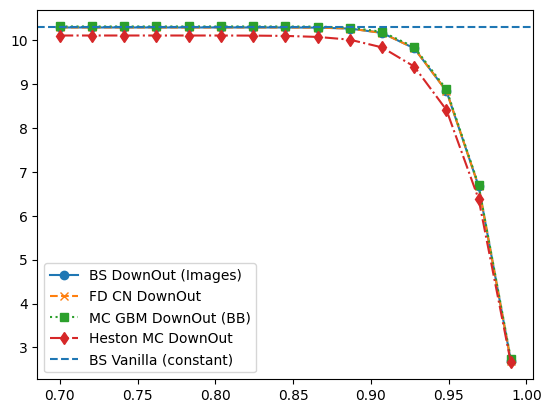

In [15]:
x = df_exp2["Barrier_frac"].to_numpy()

plt.figure()
plt.plot(x, df_exp2["BS_DownOut_Images"], linestyle="-", marker="o", label="BS DownOut (Images)")
plt.plot(x, df_exp2["FD_CN_DownOut"], linestyle="--", marker="x", label="FD CN DownOut")
plt.plot(x, df_exp2["MC_GBM_DownOut"], linestyle=":", marker="s", label="MC GBM DownOut (BB)")
plt.plot(x, df_exp2["Heston_MC_DownOut"], linestyle="-.", marker="d", label="Heston MC DownOut")
bs_van = df_exp2["BS_Vanilla"].iloc[0]
plt.axhline(bs_van, linestyle="--", label="BS Vanilla (constant)")
plt.legend()
plt.show()


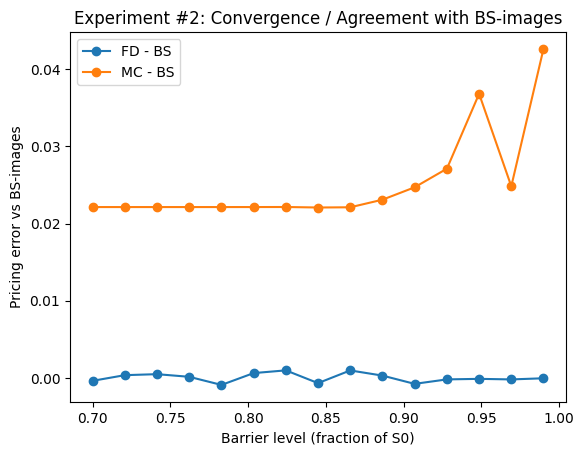

In [16]:
plt.figure()
plt.plot(x, (df_exp2["FD_CN_DownOut"] - df_exp2["BS_DownOut_Images"]), marker="o", label="FD - BS")
plt.plot(x, (df_exp2["MC_GBM_DownOut"] - df_exp2["BS_DownOut_Images"]), marker="o", label="MC - BS")
plt.xlabel("Barrier level (fraction of S0)")
plt.ylabel("Pricing error vs BS-images")
plt.title("Experiment #2: Convergence / Agreement with BS-images")
plt.legend()
plt.show()


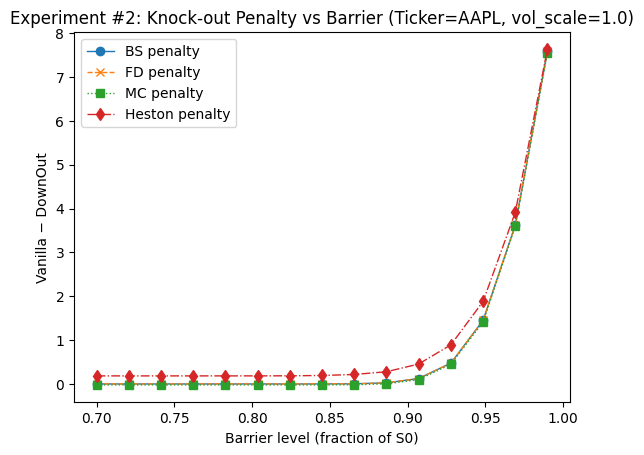

In [17]:
plt.figure()
plt.plot(x, (df_exp2["BS_Vanilla"] - df_exp2["BS_DownOut_Images"]).to_numpy(),
         linestyle="-", marker="o", linewidth=1, label="BS penalty")
plt.plot(x, (df_exp2["BS_Vanilla"] - df_exp2["FD_CN_DownOut"]).to_numpy(),
         linestyle="--", marker="x", linewidth=1, label="FD penalty")
plt.plot(x, (df_exp2["BS_Vanilla"] - df_exp2["MC_GBM_DownOut"]).to_numpy(),
         linestyle=":", marker="s", linewidth=1, label="MC penalty")
plt.plot(x, (df_exp2["BS_Vanilla"] - df_exp2["Heston_MC_DownOut"]).to_numpy(),
         linestyle="-.", marker="d", linewidth=1, label="Heston penalty")

plt.xlabel("Barrier level (fraction of S0)")
plt.ylabel("Vanilla − DownOut")
plt.title(f"Experiment #2: Knock-out Penalty vs Barrier (Ticker={ticker}, vol_scale={vol_scale_fixed})")
plt.legend()
plt.show()


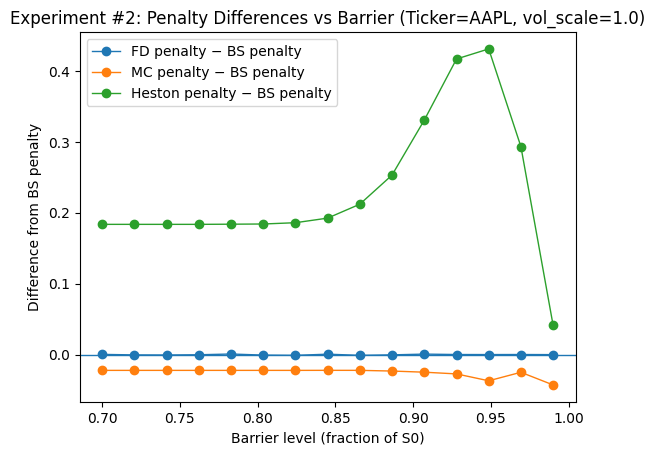

In [18]:
plt.figure()
plt.plot(x,
         ((df_exp2["BS_Vanilla"] - df_exp2["FD_CN_DownOut"]) -
          (df_exp2["BS_Vanilla"] - df_exp2["BS_DownOut_Images"])).to_numpy(),
         marker="o", linewidth=1, label="FD penalty − BS penalty")

plt.plot(x,
         ((df_exp2["BS_Vanilla"] - df_exp2["MC_GBM_DownOut"]) -
          (df_exp2["BS_Vanilla"] - df_exp2["BS_DownOut_Images"])).to_numpy(),
         marker="o", linewidth=1, label="MC penalty − BS penalty")

plt.plot(x,
         ((df_exp2["BS_Vanilla"] - df_exp2["Heston_MC_DownOut"]) -
          (df_exp2["BS_Vanilla"] - df_exp2["BS_DownOut_Images"])).to_numpy(),
         marker="o", linewidth=1, label="Heston penalty − BS penalty")

plt.axhline(0.0, linewidth=1)
plt.xlabel("Barrier level (fraction of S0)")
plt.ylabel("Difference from BS penalty")
plt.title(f"Experiment #2: Penalty Differences vs Barrier (Ticker={ticker}, vol_scale={vol_scale_fixed})")
plt.legend()
plt.show()


### Experiment 3: Volatility Sweep

In [19]:
# Experiment #3 settings
ticker = "AAPL"
barrier_fixed = 0.85
n_vols = 15
# Sweep volatility scales (adjust as desired)
vol_grid = np.round(np.linspace(0.5, 2.0, n_vols), 3).tolist()

df_exp3 = run_barrier_pricing_grid(
    tickers=[ticker],
    barrier_levels=[barrier_fixed],
    vol_scales=vol_grid,
    n_paths=N_PATHS,
    n_steps_gbm=N_STEPS_GBM,
    fd_smax_mult=4.0,
    fd_M=1200,
    fd_N=3000
)

df_exp3 = df_exp3.sort_values(["vol_scale"]).reset_index(drop=True)

df_exp3[[
    "Ticker", "Barrier_frac", "vol_scale", "sigma",
    "BS_Vanilla", "BS_DownOut_Images", "FD_CN_DownOut", "MC_GBM_DownOut", "Heston_MC_DownOut"
]].head()


Running Trial 1/15
Running Trial 2/15
Running Trial 3/15
Running Trial 4/15
Running Trial 5/15
Running Trial 6/15
Running Trial 7/15
Running Trial 8/15
Running Trial 9/15
Running Trial 10/15
Running Trial 11/15
Running Trial 12/15
Running Trial 13/15
Running Trial 14/15
Running Trial 15/15


,Ticker,Barrier_frac,vol_scale,sigma,BS_Vanilla,BS_DownOut_Images,FD_CN_DownOut,MC_GBM_DownOut,Heston_MC_DownOut
0,AAPL,0.85,0.500,0.128671,5.488002,5.488002,5.487934,5.498791,5.215389
1,AAPL,0.85,0.607,0.156207,6.512938,6.512938,6.512888,6.526061,6.272281
2,AAPL,0.85,0.714,0.183742,7.539199,7.539198,7.539160,7.554708,7.322711
3,AAPL,0.85,0.821,0.211278,8.566193,8.566176,8.566145,8.584106,8.363751
4,AAPL,0.85,0.929,0.239071,9.603194,9.602981,9.602952,9.623527,9.407080


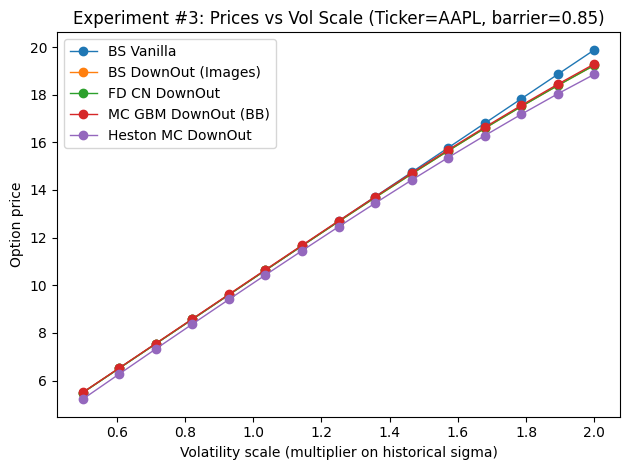

In [20]:
x = df_exp3["vol_scale"].to_numpy()

plt.figure()
plt.plot(x, df_exp3["BS_Vanilla"].to_numpy(), marker="o", linewidth=1, label="BS Vanilla")
plt.plot(x, df_exp3["BS_DownOut_Images"].to_numpy(), marker="o", linewidth=1, label="BS DownOut (Images)")
plt.plot(x, df_exp3["FD_CN_DownOut"].to_numpy(), marker="o", linewidth=1, label="FD CN DownOut")
plt.plot(x, df_exp3["MC_GBM_DownOut"].to_numpy(), marker="o", linewidth=1, label="MC GBM DownOut (BB)")
plt.plot(x, df_exp3["Heston_MC_DownOut"].to_numpy(), marker="o", linewidth=1, label="Heston MC DownOut")

plt.xlabel("Volatility scale (multiplier on historical sigma)")
plt.ylabel("Option price")
plt.title(f"Experiment #3: Prices vs Vol Scale (Ticker={ticker}, barrier={barrier_fixed})")
plt.legend()
plt.tight_layout()
plt.show()


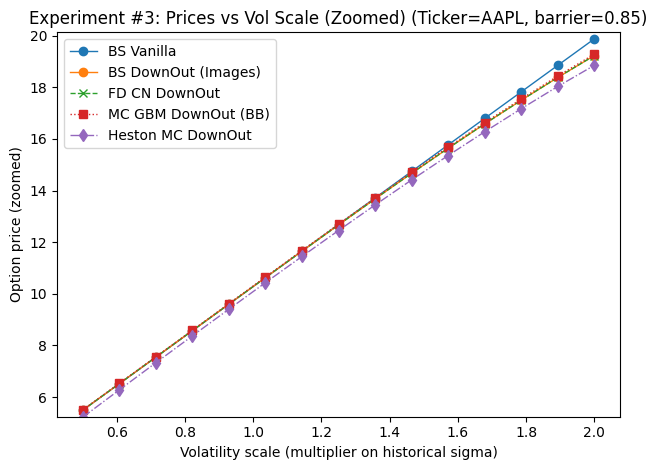

In [21]:
# Pick a zoom window automatically around the BS DownOut curve
y_ref = df_exp3["BS_DownOut_Images"].to_numpy()
pad = 0.25  # widen/narrow as desired

plt.figure()
plt.plot(x, df_exp3["BS_Vanilla"].to_numpy(), marker="o", linewidth=1, label="BS Vanilla")
plt.plot(x, df_exp3["BS_DownOut_Images"].to_numpy(), marker="o", linewidth=1, label="BS DownOut (Images)")
plt.plot(x, df_exp3["FD_CN_DownOut"].to_numpy(), marker="x", linewidth=1, linestyle="--", label="FD CN DownOut")
plt.plot(x, df_exp3["MC_GBM_DownOut"].to_numpy(), marker="s", linewidth=1, linestyle=":", label="MC GBM DownOut (BB)")
plt.plot(x, df_exp3["Heston_MC_DownOut"].to_numpy(), marker="d", linewidth=1, linestyle="-.", label="Heston MC DownOut")

plt.ylim(y_ref.min() - pad, df_exp3["BS_Vanilla"].max() + pad)  # zoom near the cluster
plt.xlabel("Volatility scale (multiplier on historical sigma)")
plt.ylabel("Option price (zoomed)")
plt.title(f"Experiment #3: Prices vs Vol Scale (Zoomed) (Ticker={ticker}, barrier={barrier_fixed})")
plt.legend()
plt.tight_layout()
plt.show()


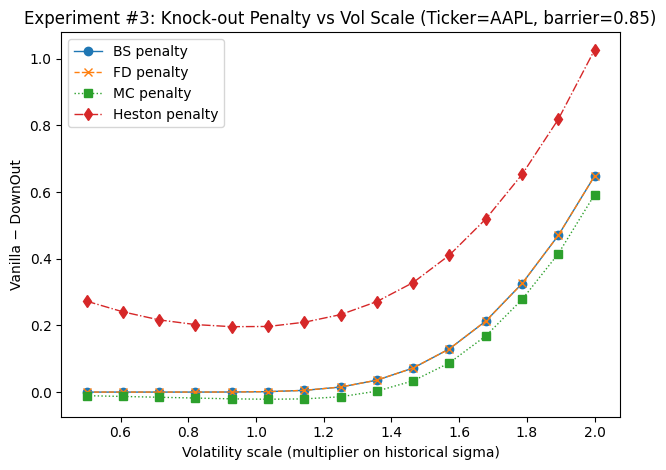

In [22]:
pen_bs = (df_exp3["BS_Vanilla"] - df_exp3["BS_DownOut_Images"]).to_numpy()
pen_fd = (df_exp3["BS_Vanilla"] - df_exp3["FD_CN_DownOut"]).to_numpy()
pen_mc = (df_exp3["BS_Vanilla"] - df_exp3["MC_GBM_DownOut"]).to_numpy()
pen_h  = (df_exp3["BS_Vanilla"] - df_exp3["Heston_MC_DownOut"]).to_numpy()

plt.figure()
plt.plot(x, pen_bs, marker="o", linewidth=1, label="BS penalty")
plt.plot(x, pen_fd, marker="x", linewidth=1, linestyle="--", label="FD penalty")
plt.plot(x, pen_mc, marker="s", linewidth=1, linestyle=":", label="MC penalty")
plt.plot(x, pen_h,  marker="d", linewidth=1, linestyle="-.", label="Heston penalty")

plt.xlabel("Volatility scale (multiplier on historical sigma)")
plt.ylabel("Vanilla − DownOut")
plt.title(f"Experiment #3: Knock-out Penalty vs Vol Scale (Ticker={ticker}, barrier={barrier_fixed})")
plt.legend()
plt.tight_layout()
plt.show()


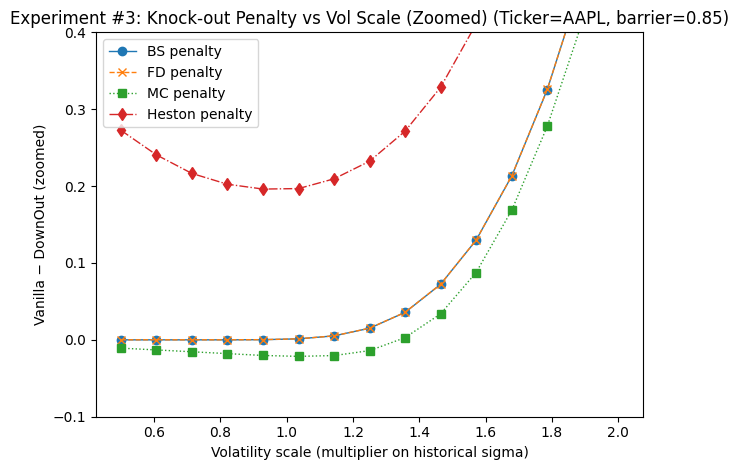

In [23]:
plt.figure()
plt.plot(x, pen_bs, marker="o", linewidth=1, label="BS penalty")
plt.plot(x, pen_fd, marker="x", linewidth=1, linestyle="--", label="FD penalty")
plt.plot(x, pen_mc, marker="s", linewidth=1, linestyle=":", label="MC penalty")
plt.plot(x, pen_h,  marker="d", linewidth=1, linestyle="-.", label="Heston penalty")

plt.ylim(-0.10, 0.40)  # zoom: adjust if your curves are larger/smaller
plt.xlabel("Volatility scale (multiplier on historical sigma)")
plt.ylabel("Vanilla − DownOut (zoomed)")
plt.title(f"Experiment #3: Knock-out Penalty vs Vol Scale (Zoomed) (Ticker={ticker}, barrier={barrier_fixed})")
plt.legend()
plt.tight_layout()
plt.show()


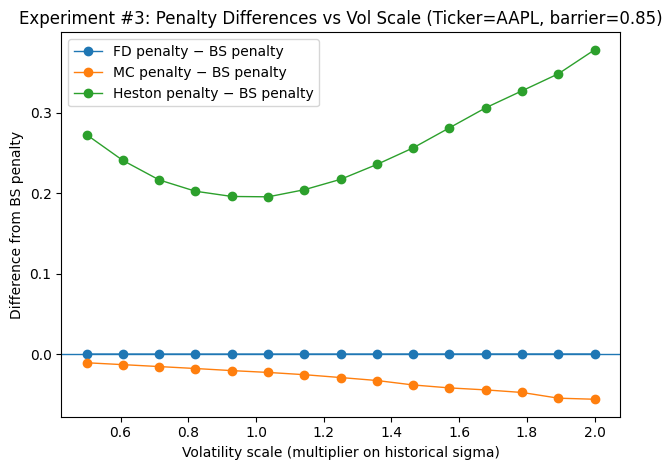

In [24]:
plt.figure()
plt.plot(x, pen_fd - pen_bs, marker="o", linewidth=1, label="FD penalty − BS penalty")
plt.plot(x, pen_mc - pen_bs, marker="o", linewidth=1, label="MC penalty − BS penalty")
plt.plot(x, pen_h  - pen_bs, marker="o", linewidth=1, label="Heston penalty − BS penalty")
plt.axhline(0.0, linewidth=1)

plt.xlabel("Volatility scale (multiplier on historical sigma)")
plt.ylabel("Difference from BS penalty")
plt.title(f"Experiment #3: Penalty Differences vs Vol Scale (Ticker={ticker}, barrier={barrier_fixed})")
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
# Sanity Check with Confidence Intervals
# Market / option inputs

ticker = "AAPL"
TRADING_DAYS = 252

# maturity (match Experiment 3)
option_days = 30
T = option_days / TRADING_DAYS

r = 0.04        # risk-free rate
q = 0.0         # dividend yield

# Load data and compute S0, sigma

raw = yf.download(ticker, period="3y", interval="1d", auto_adjust=False, progress=False)
adj = raw["Adj Close"].dropna().ffill()

S0 = float(adj.iloc[-1])
K = S0  # ATM call

# historical volatility
logret = np.log(adj).diff().dropna()
sigma_hist = float(logret.std(ddof=1) * np.sqrt(TRADING_DAYS))

# Experiment 3 volatility scale
vol_scale = 1.0
sigma = sigma_hist * vol_scale

# Barrier

barrier_frac = 0.85
H = barrier_frac * S0

# Monte Carlo parameters

seed = 42
n_paths = 250_000
n_steps_gbm = max(200, int(4 * option_days))

print("Inputs:")
print(dict(
    ticker=ticker,
    S0=S0,
    K=K,
    H=H,
    T=T,
    r=r,
    q=q,
    sigma=sigma,
    n_paths=n_paths,
    n_steps_gbm=n_steps_gbm
))


Inputs:
{'ticker': 'AAPL', 'S0': 272.6099853515625, 'K': 272.6099853515625, 'H': 231.7184875488281, 'T': 0.11904761904761904, 'r': 0.04, 'q': 0.0, 'sigma': 0.25733468551556055, 'n_paths': 250000, 'n_steps_gbm': 200}


/tmp/ipython-input-655230628.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(adj.iloc[-1])
/tmp/ipython-input-655230628.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma_hist = float(logret.std(ddof=1) * np.sqrt(TRADING_DAYS))


In [26]:
mc_v, se_v = mc_gbm_vanilla_call_with_se(S0, K, T, r, q, sigma,
                                        n_paths=n_paths, seed=seed, antithetic=True)

mc_do, se_do = mc_gbm_down_and_out_call_bb_with_se(S0, K, H, T, r, q, sigma,
                                                  n_steps=n_steps_gbm, n_paths=n_paths,
                                                  seed=seed, antithetic=True)

mc_pen = mc_v - mc_do
mc_pen_se = (se_v**2 + se_do**2)**0.5

print("MC vanilla:", mc_v, "SE:", se_v, "95% CI:", (mc_v-1.96*se_v, mc_v+1.96*se_v))
print("MC downout:", mc_do, "SE:", se_do, "95% CI:", (mc_do-1.96*se_do, mc_do+1.96*se_do))
print("MC penalty:", mc_pen, "SE:", mc_pen_se, "95% CI:", (mc_pen-1.96*mc_pen_se, mc_pen+1.96*mc_pen_se))


MC vanilla: 10.318132008807064 SE: 0.030798174273440008 95% CI: (10.257767587231122, 10.378496430383006)
MC downout: 10.318069819458943 SE: 0.030728599653089255 95% CI: (10.257841764138888, 10.378297874778998)
MC penalty: 6.218934812096677e-05 SE: 0.04350602688383552 95% CI: (-0.08520962334419666, 0.08533400204043859)


### Experiment 4: Time-to-Maturity Sweep

In [27]:
# =========================
# Experiment 4: Time-to-Maturity Sweep
# =========================

ticker = "AAPL"
barrier_fixed = 0.85
vol_scale_fixed = 1.0

# maturities to test (days)
maturity_days_list = [7, 14, 30, 60, 90, 120, 180]

# runtime controls (use your normal "report-quality" settings if desired)


# FD settings (match your stable choices)
fd_smax_mult = 4.0
fd_M = 1200
fd_N = 3000

print("Experiment 4 inputs:")
print(dict(
    ticker=ticker,
    barrier_fixed=barrier_fixed,
    vol_scale_fixed=vol_scale_fixed,
    maturity_days_list=maturity_days_list,
    n_paths=N_PATHS,
    n_steps_gbm=N_STEPS_GBM,
    fd_smax_mult=fd_smax_mult,
    fd_M=fd_M,
    fd_N=fd_N,
))


Experiment 4 inputs:
{'ticker': 'AAPL', 'barrier_fixed': 0.85, 'vol_scale_fixed': 1.0, 'maturity_days_list': [7, 14, 30, 60, 90, 120, 180], 'n_paths': 250000, 'n_steps_gbm': 500, 'fd_smax_mult': 4.0, 'fd_M': 1200, 'fd_N': 3000}


In [28]:
# Run pricing for each maturity; each maturity becomes a row
rows = []
for option_days in maturity_days_list:
    df_tmp = run_barrier_pricing_grid(
        tickers=[ticker],
        barrier_levels=[barrier_fixed],
        vol_scales=[vol_scale_fixed],
        option_days=option_days,     # <-- your function must accept this;
                                            # if yours doesn't, see note below
        n_paths=n_paths,
        n_steps_gbm=n_steps_gbm,
        fd_smax_mult=fd_smax_mult,
        fd_M=fd_M,
        fd_N=fd_N
    )
    rows.append(df_tmp)

df_exp4 = pd.concat(rows, ignore_index=True)

# Sort by maturity for plotting
df_exp4 = df_exp4.sort_values("option_days").reset_index(drop=True)

df_exp4[[
    "Ticker", "option_days", "T_years", "Barrier_frac", "sigma",
    "MC_GBM_Vanilla", "BS_Vanilla",
    "MC_GBM_DownOut", "BS_DownOut_Images", "FD_CN_DownOut", "Heston_MC_DownOut"
]]


Running Trial 1/1
Running Trial 1/1
Running Trial 1/1
Running Trial 1/1
Running Trial 1/1
Running Trial 1/1
Running Trial 1/1


,Ticker,option_days,T_years,Barrier_frac,sigma,MC_GBM_Vanilla,BS_Vanilla,MC_GBM_DownOut,BS_DownOut_Images,FD_CN_DownOut,Heston_MC_DownOut
0,AAPL,7,0.027778,0.85,0.257335,4.825793,4.814077,4.826516,4.814077,4.814030,4.789419
1,AAPL,14,0.055556,0.85,0.257338,6.910383,6.893218,6.911177,6.893218,6.893184,6.829042
2,AAPL,30,0.119048,0.85,0.257331,10.321317,10.294737,10.321255,10.293984,10.293954,10.098959
3,AAPL,60,0.238095,0.85,0.257332,14.957449,14.917083,14.904237,14.863230,14.863139,14.249140
4,AAPL,90,0.357143,0.85,0.257334,18.648450,18.596298,18.369398,18.322191,18.322049,17.217197
5,AAPL,120,0.476190,0.85,0.257337,21.845231,21.782283,21.180570,21.103462,21.103296,19.592375
6,AAPL,180,0.714286,0.85,0.257340,27.384446,27.301473,25.506486,25.400989,25.400812,23.396712


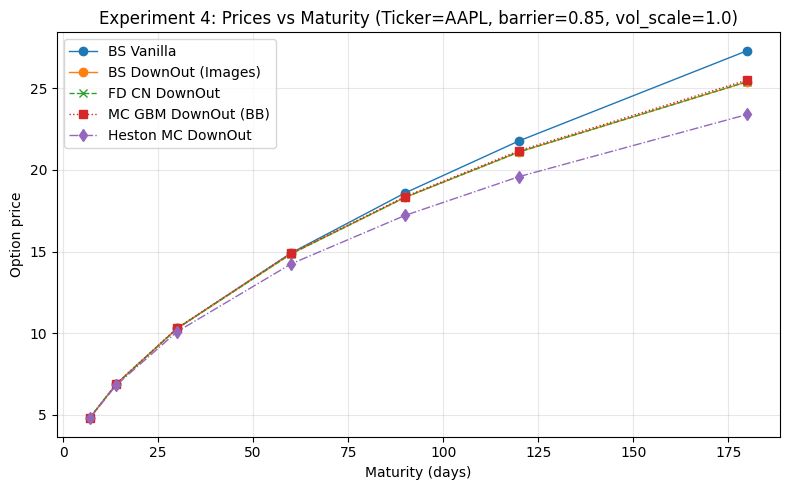

In [29]:
x = df_exp4["option_days"].to_numpy()

plt.figure(figsize=(8, 5))
plt.plot(x, df_exp4["BS_Vanilla"].to_numpy(), marker="o", linewidth=1, label="BS Vanilla")
plt.plot(x, df_exp4["BS_DownOut_Images"].to_numpy(), marker="o", linewidth=1, label="BS DownOut (Images)")
plt.plot(x, df_exp4["FD_CN_DownOut"].to_numpy(), marker="x", linewidth=1, linestyle="--", label="FD CN DownOut")
plt.plot(x, df_exp4["MC_GBM_DownOut"].to_numpy(), marker="s", linewidth=1, linestyle=":", label="MC GBM DownOut (BB)")
plt.plot(x, df_exp4["Heston_MC_DownOut"].to_numpy(), marker="d", linewidth=1, linestyle="-.", label="Heston MC DownOut")

plt.xlabel("Maturity (days)")
plt.ylabel("Option price")
plt.title(f"Experiment 4: Prices vs Maturity (Ticker={ticker}, barrier={barrier_fixed}, vol_scale={vol_scale_fixed})")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


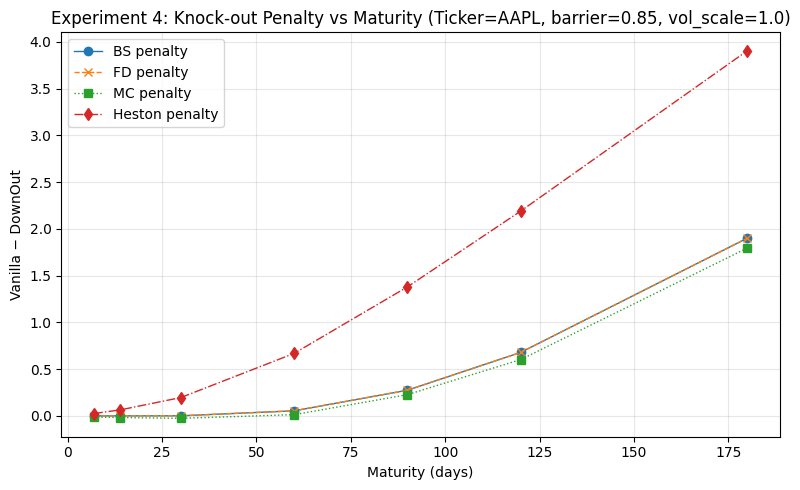

In [30]:
pen_bs = (df_exp4["BS_Vanilla"] - df_exp4["BS_DownOut_Images"]).to_numpy()
pen_fd = (df_exp4["BS_Vanilla"] - df_exp4["FD_CN_DownOut"]).to_numpy()
pen_mc = (df_exp4["BS_Vanilla"] - df_exp4["MC_GBM_DownOut"]).to_numpy()
pen_h  = (df_exp4["BS_Vanilla"] - df_exp4["Heston_MC_DownOut"]).to_numpy()

plt.figure(figsize=(8, 5))
plt.plot(x, pen_bs, marker="o", linewidth=1, label="BS penalty")
plt.plot(x, pen_fd, marker="x", linewidth=1, linestyle="--", label="FD penalty")
plt.plot(x, pen_mc, marker="s", linewidth=1, linestyle=":", label="MC penalty")
plt.plot(x, pen_h,  marker="d", linewidth=1, linestyle="-.", label="Heston penalty")

plt.xlabel("Maturity (days)")
plt.ylabel("Vanilla − DownOut")
plt.title(f"Experiment 4: Knock-out Penalty vs Maturity (Ticker={ticker}, barrier={barrier_fixed}, vol_scale={vol_scale_fixed})")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Experiment 5: Monte Carlo Convergence Analysis

In [31]:
# =========================
# Experiment 5: MC Convergence (with uncertainty)
# =========================

ticker = "AAPL"
barrier_fixed = 0.85
vol_scale_fixed = 1.0

# Choose maturity consistent with your experiments
option_days = 30
TRADING_DAYS = 252
T = option_days / TRADING_DAYS

# MC controls
seed = 42
antithetic = True

# Baseline time steps (used for the paths sweep)
n_steps_gbm_base = 500

# Paths sweep (log-spaced-ish)
paths_list = [5_000, 10_000, 25_000, 50_000, 100_000, 250_000]

print("Experiment 5 settings:")
print(dict(
    ticker=ticker, barrier_fixed=barrier_fixed, vol_scale_fixed=vol_scale_fixed,
    option_days=option_days, T=T,
    seed=seed, antithetic=antithetic,
    n_steps_gbm_base=n_steps_gbm_base, paths_list=paths_list
))


Experiment 5 settings:
{'ticker': 'AAPL', 'barrier_fixed': 0.85, 'vol_scale_fixed': 1.0, 'option_days': 30, 'T': 0.11904761904761904, 'seed': 42, 'antithetic': True, 'n_steps_gbm_base': 500, 'paths_list': [5000, 10000, 25000, 50000, 100000, 250000]}


In [32]:

raw = yf.download(ticker, period="3y", interval="1d", auto_adjust=False, progress=False)
adj = raw["Adj Close"].dropna().ffill()

S0 = float(adj.iloc[-1])
K = S0

logret = np.log(adj).diff().dropna()
sigma_hist = float(logret.std(ddof=1) * np.sqrt(TRADING_DAYS))
sigma = sigma_hist * vol_scale_fixed

H = barrier_fixed * S0

print("Inputs:", dict(S0=S0, K=K, H=H, T=T, r=r, q=q, sigma=sigma))


Inputs: {'S0': 272.44000244140625, 'K': 272.44000244140625, 'H': 231.5740020751953, 'T': 0.11904761904761904, 'r': 0.04, 'q': 0.0, 'sigma': 0.25734175950123167}


/tmp/ipython-input-1498540150.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(adj.iloc[-1])
/tmp/ipython-input-1498540150.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma_hist = float(logret.std(ddof=1) * np.sqrt(TRADING_DAYS))


In [33]:
bs_v = bs_call_price(S0, K, T, r, q, sigma)
bs_do = bs_down_and_out_call(S0, K, H, T, r, q, sigma)

print("BS Vanilla:", bs_v)
print("BS DownOut (Images):", bs_do)
print("BS KO penalty:", bs_v - bs_do)


BS Vanilla: 10.285407520722828
BS DownOut (Images): 10.284654559547972
BS KO penalty: 0.0007529611748555709


In [34]:
rows = []
for n_paths in paths_list:
    mc_v, se_v = mc_gbm_vanilla_call_with_se(
        S0, K, T, r, q, sigma,
        n_paths=n_paths, seed=seed, antithetic=antithetic
    )
    mc_do, se_do = mc_gbm_down_and_out_call_bb_with_se(
        S0, K, H, T, r, q, sigma,
        n_steps=n_steps_gbm_base, n_paths=n_paths,
        seed=seed, antithetic=antithetic
    )

    rows.append({
        "n_paths": n_paths,
        "MC_Vanilla": mc_v, "SE_Vanilla": se_v,
        "MC_DownOut": mc_do, "SE_DownOut": se_do,
        "abs_err_v": abs(mc_v - bs_v),
        "abs_err_do": abs(mc_do - bs_do),
        "ci_half_v": 1.96 * se_v,
        "ci_half_do": 1.96 * se_do
    })

df_exp5_paths = pd.DataFrame(rows)
df_exp5_paths


,n_paths,MC_Vanilla,SE_Vanilla,MC_DownOut,SE_DownOut,abs_err_v,abs_err_do,ci_half_v,ci_half_do
0,5000,10.268182,0.219158,10.076931,0.213538,0.017225,0.207724,0.429551,0.418534
1,10000,10.230477,0.153530,10.144231,0.151118,0.054930,0.140423,0.300920,0.296191
2,25000,10.270557,0.097440,10.344015,0.097231,0.014850,0.059361,0.190982,0.190572
3,50000,10.284134,0.068713,10.275060,0.068506,0.001274,0.009595,0.134678,0.134271
4,100000,10.298173,0.048607,10.293530,0.048508,0.012766,0.008876,0.095271,0.095075
5,250000,10.311963,0.030780,10.306657,0.030695,0.026556,0.022003,0.060328,0.060163


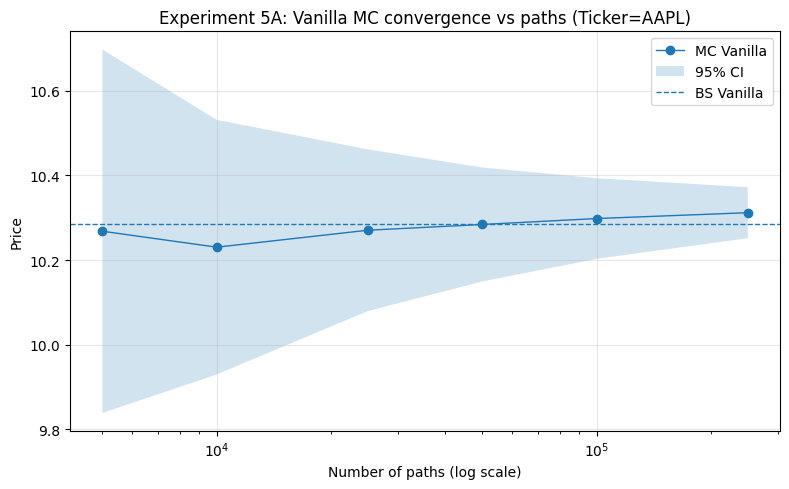

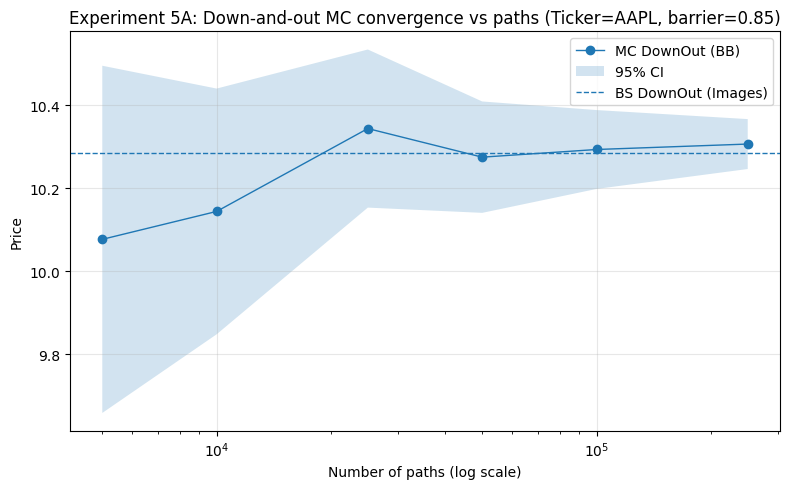

In [35]:
x = df_exp5_paths["n_paths"].to_numpy()

# Vanilla
plt.figure(figsize=(8,5))
y = df_exp5_paths["MC_Vanilla"].to_numpy()
ci = df_exp5_paths["ci_half_v"].to_numpy()

plt.plot(x, y, marker="o", linewidth=1, label="MC Vanilla")
plt.fill_between(x, y-ci, y+ci, alpha=0.2, label="95% CI")
plt.axhline(bs_v, linewidth=1, linestyle="--", label="BS Vanilla")

plt.xscale("log")
plt.xlabel("Number of paths (log scale)")
plt.ylabel("Price")
plt.title(f"Experiment 5A: Vanilla MC convergence vs paths (Ticker={ticker})")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Down-and-out
plt.figure(figsize=(8,5))
y = df_exp5_paths["MC_DownOut"].to_numpy()
ci = df_exp5_paths["ci_half_do"].to_numpy()

plt.plot(x, y, marker="o", linewidth=1, label="MC DownOut (BB)")
plt.fill_between(x, y-ci, y+ci, alpha=0.2, label="95% CI")
plt.axhline(bs_do, linewidth=1, linestyle="--", label="BS DownOut (Images)")

plt.xscale("log")
plt.xlabel("Number of paths (log scale)")
plt.ylabel("Price")
plt.title(f"Experiment 5A: Down-and-out MC convergence vs paths (Ticker={ticker}, barrier={barrier_fixed})")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


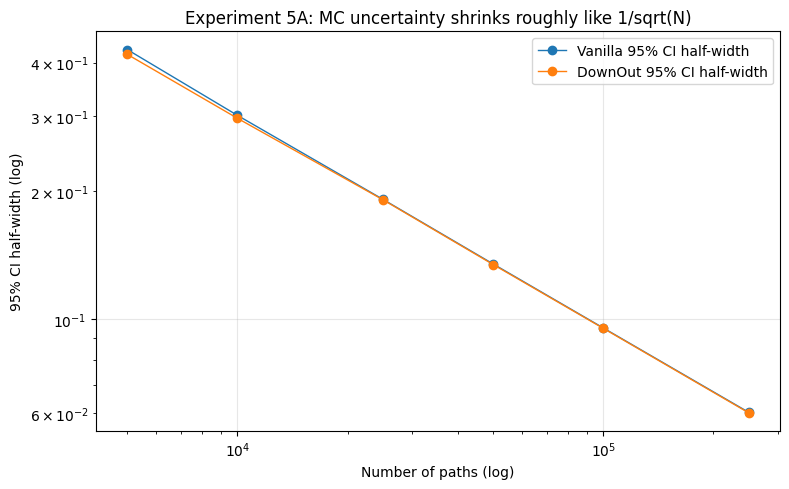

In [36]:
plt.figure(figsize=(8,5))
plt.plot(x, df_exp5_paths["ci_half_v"], marker="o", linewidth=1, label="Vanilla 95% CI half-width")
plt.plot(x, df_exp5_paths["ci_half_do"], marker="o", linewidth=1, label="DownOut 95% CI half-width")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of paths (log)")
plt.ylabel("95% CI half-width (log)")
plt.title("Experiment 5A: MC uncertainty shrinks roughly like 1/sqrt(N)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [37]:
n_paths_steps_sweep = 250_000  # keep fixed; bump if you want cleaner
steps_list = [25, 50, 100, 200, 500, 1000]

rows = []
for n_steps in steps_list:
    mc_do, se_do = mc_gbm_down_and_out_call_bb_with_se(
        S0, K, H, T, r, q, sigma,
        n_steps=n_steps, n_paths=n_paths_steps_sweep,
        seed=seed, antithetic=antithetic
    )
    rows.append({
        "n_steps": n_steps,
        "MC_DownOut": mc_do,
        "SE_DownOut": se_do,
        "ci_half_do": 1.96*se_do,
        "abs_err_do": abs(mc_do - bs_do)
    })

df_exp5_steps = pd.DataFrame(rows)
df_exp5_steps


,n_steps,MC_DownOut,SE_DownOut,ci_half_do,abs_err_do
0,25,10.278804,0.030591,0.059958,0.005851
1,50,10.282659,0.030645,0.060065,0.001996
2,100,10.311572,0.030755,0.060280,0.026918
3,200,10.311901,0.030710,0.060192,0.027246
4,500,10.306657,0.030695,0.060163,0.022003
5,1000,10.272925,0.030605,0.059985,0.011730


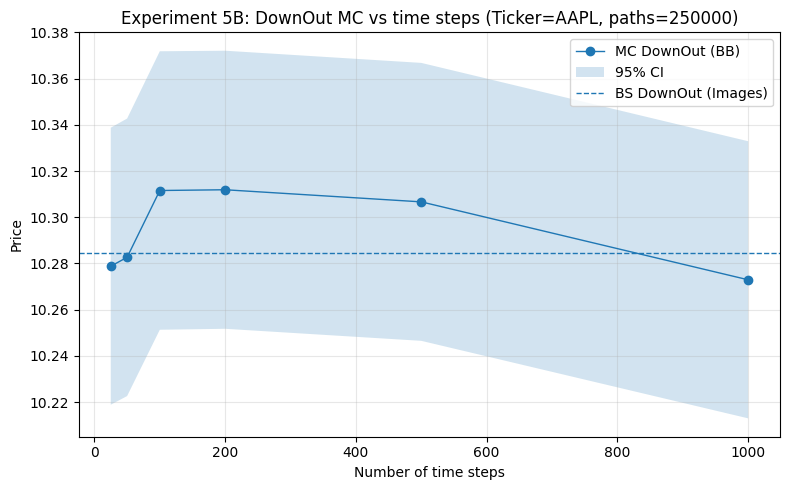

In [38]:
x = df_exp5_steps["n_steps"].to_numpy()
y = df_exp5_steps["MC_DownOut"].to_numpy()
ci = df_exp5_steps["ci_half_do"].to_numpy()

plt.figure(figsize=(8,5))
plt.plot(x, y, marker="o", linewidth=1, label="MC DownOut (BB)")
plt.fill_between(x, y-ci, y+ci, alpha=0.2, label="95% CI")
plt.axhline(bs_do, linewidth=1, linestyle="--", label="BS DownOut (Images)")

plt.xlabel("Number of time steps")
plt.ylabel("Price")
plt.title(f"Experiment 5B: DownOut MC vs time steps (Ticker={ticker}, paths={n_paths_steps_sweep})")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


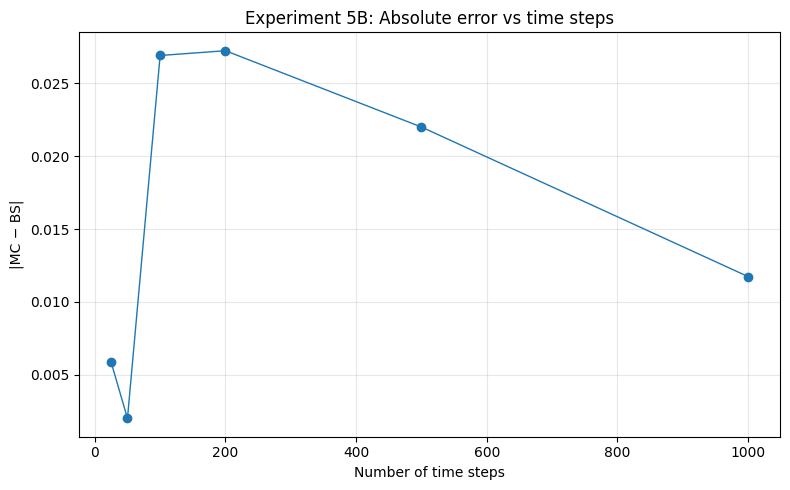

In [39]:
plt.figure(figsize=(8,5))
plt.plot(df_exp5_steps["n_steps"], df_exp5_steps["abs_err_do"], marker="o", linewidth=1)
plt.xlabel("Number of time steps")
plt.ylabel("|MC − BS|")
plt.title("Experiment 5B: Absolute error vs time steps")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()